#### &nbsp;
# **Twitter Sentiment Analysis**
#### Author: &nbsp; Ankit S Kumar
#### &nbsp;

## Project Description
In the era of digital communication, social media platforms like Twitter have become pivotal for individuals and organisations to express opinions, share news, and engage with communities. With millions of tweets generated daily, Twitter provides a rich source of data that can be analysed to gauge public sentiment on various topics. Twitter sentiment analysis leverages Natural Language Processing (NLP) and machine learning techniques to identify and classify the sentiment behind tweets, categorising them as positive, negative, or neutral.

In this project, we perform Twitter Sentiment Analysis employing classification models from Scikit-Learn library and categorise the general sentiment of tweets as either positive or negative. This project demonstrates different elements of text processing, feature extraction, and model training. Throughout the project, the Python programming language is utilised. 

## Objectives
- To preprocess and clean tweet text data.
- To convert textual data into numerical features using TF-IDF vectorization.
- To train machine learning models to classify the sentiment of tweets.
- To evaluate and compare models' performance using appropriate metrics or KPIs.

## Project Workflow

### 1. Import libraries
Import necessary libraries for data handling, preprocessing, and model building.
- *Pandas*: For data manipulation and analysis.
- *NumPy*: For numerical computations.
- *NLTK* and *Re*: For text preprocessing and tokenization.
- *Scikit-Learn*: For machine learning algorithms and feature extraction.
- *Matplotlib*: For data visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, re
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB


### 2. Import the Twitter dataset
The Twitter dataset is loaded from the nltk repository. It consists of two lists (containing tweets as strings), each named with corresponding sentiments -- positive or negative. After importing the dataset, tweets are labelled as 1 for positive and 0 for negative. Finally, the dataset is converted into Pandas dataframe for efficient data processing.

In [72]:
# Loading twitter data (lists) from nltk
nltk.download('twitter_samples')
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = positive_tweets + negative_tweets
label = np.zeros(len(tweets),dtype='int8')
label[:len(positive_tweets)] = 1

# Converting lists to Pandas Dataframes
tweets_df = pd.DataFrame([label, tweets], index=['label', 'tweet']).T
tweets_df['label'] = tweets_df['label'].astype('int8')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


### 3. Exploratory data analysis

After collecting the Twitter dataset, the next crucial step is to perform Exploratory Data Analysis (EDA). EDA helps in understanding the dataset and gaining insights that may inform further preprocessing and modelling steps.

##### Checking the dataset structure:

In [73]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int8  
 1   tweet   10000 non-null  object
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


In [74]:
tweets_df.head()

,label,tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1,@Lamb2ja Hey James! How odd :/ Please call our...
2,1,@DespiteOfficial we had a listen last night :)...
3,1,@97sides CONGRATS :)
4,1,yeaaaah yippppy!!! my accnt verified rqst has...


##### Missing Values and Duplicates:
The dataset is checked for missing values and duplicates. Addressing these issues ensures the data's integrity and quality.

In [75]:
#Checking for null cells
tweets_df.isnull().sum()

label    0
tweet    0
dtype: int64

In [76]:
#Checking for duplicate tweets
tweets_df['tweet'].duplicated().sum()

0

##### Tweet Length Statistics:
# +=========Update sentiment distribution description==============
Descriptive statistics for tweet lengths are calculated separately for positive and negative tweets. This reveals if there's a significant difference in tweet lengths between the two sentiments. In some projects, this information could be used as an interesting feature for the model.

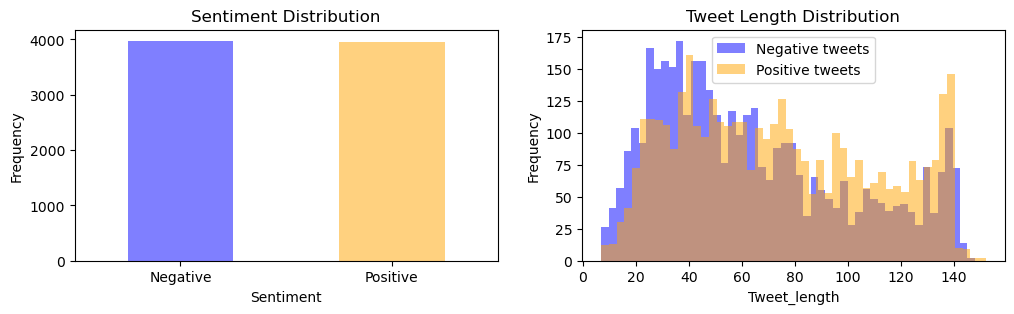

In [70]:
def plot_tweet_dist(df):
    # Get the length of the tweets
    df['tweet_length'] = df['tweet'].apply(len)
    
    # Visualize the distribution of sentiments
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    df['label'].value_counts().plot(kind='bar', alpha=0.5, color=['blue', 'orange'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'],rotation=0)
    
    plt.subplot(122)
    #Plotting the histogram of tweet lengths
    pos_tweet_len = df[df['label']==1]['tweet_length']
    neg_tweet_len = df[df['label']==0]['tweet_length']
    neg_tweet_len.plot(kind='hist', alpha=0.5, label='Negative tweets', bins=50,color='blue')
    pos_tweet_len.plot(kind='hist', alpha=0.5, label='Positive tweets', bins=50, color='orange')
    plt.title('Tweet Length Distribution')
    plt.xlabel('Tweet_length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_tweet_dist(tweets_df)

In [8]:
tweet_stats = pd.concat([pos_tweet_len.describe(), neg_tweet_len.describe()], axis=1)
tweet_stats.columns = ['Positive tweets', 'Negative tweets']
tweet_stats

,Positive tweets,Negative tweets
count,4000.000000,4000.000000
mean,73.711250,63.722750
std,36.903487,36.727042
min,7.000000,7.000000
25%,41.000000,34.000000
50%,69.000000,55.000000
75%,103.000000,88.000000
max,152.000000,148.000000


**Verdict**: In the dataset, there are 5000 tweets, each for positive and negative sentiments. Positive tweets tend to be longer on average than negative tweets. The mean length of positive tweets is about 10 characters longer than that of negative tweets.

### 4. Data Preprocessing
Data preprocessing is an important step in the workflow of NLP projects like sentiment analysis. It involves transforming raw/unstructured text data into a clean and structured format that improves the accuracy and efficiency of machine learning models. In the current dataset, each tweet is preprocessed by employing a pipeline that performs the following functions:
- *Cleaning*: Convert text to lowercase and remove URLs, mentions, hashtags, punctuation, etc.
- *Tokenization*: Split the text into individual words (tokens) to perform stopword removal and stemming.
- *Stopword Removal*: Remove common words that do not contribute much to the sentiment (e.g., "the", "is", "and").
- *Stemming*: Convert words to their base forms that reduces the number of unique words in the dataset. (e.g., "connect," "connected," "connecting," and "connection" can all be reduced to "connect")

In [9]:
# Defining function to preprocess tweets

rx_tick = re.compile(r'\$\w*') # remove stock market tickers like $GE
rx_handle = re.compile(r'\@\w*') # remove handles like @user
rx_RT = re.compile(r'^RT[\s]+')# remove old style retweet text "RT"
rx_hyp = re.compile(r'https?://[^\s\n\r]+') # remove hyperlinks
rx_hash = re.compile(r'#') #removing the hash # sign from the hashtag
rx_alpha = re.compile(r'[^A-Za-z0-9 ]+') #only retain alphabets and numbers

nltk_tokenize = TweetTokenizer(reduce_len=True).tokenize #Tokenization
nltk.download('stopwords')
stop_words = set(stopwords.words('english') +['im'] ) #Stopword removal including "I'm".
nltk_stem = SnowballStemmer(language='english').stem #Stemming

def tweet_preprocess_pipeline(tweet):

    tweet = tweet.lower()
    tweet = rx_tick.sub('',tweet)
    tweet = rx_handle.sub('',tweet)
    tweet = rx_RT.sub('',tweet)
    tweet = rx_hyp.sub('',tweet)
    tweet = rx_hash.sub('',tweet)
    tweet = rx_alpha.sub('',tweet)
    tokens = nltk_tokenize(tweet)
    tokens = [nltk_stem(w) for w in tokens if w not in stop_words and len(w)>1]
    tweet = ' '.join(tokens) 
    
    return tweet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Preprocess tweets using a pipeline
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(tweet_preprocess_pipeline)

#Removing rows with empty "cleaned_tweet" column
tweets_df = tweets_df[tweets_df['cleaned_tweet'].apply(lambda x: x.strip() != '')]
tweets_df.reset_index(drop=True, inplace=True)

tweets_df

,label,tweet,tweet_length,cleaned_tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,111,followfriday top engag member communiti week
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,126,hey jame odd pleas call contact centr 02392441...
2,1,@DespiteOfficial we had a listen last night :)...,107,listen last night bleed amaz track scotland
3,1,@97sides CONGRATS :),20,congrat
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,106,yeaaah yipppi accnt verifi rqst succeed got bl...
...,...,...,...,...
7929,0,Amelia didnt stalk my twitter :(,32,amelia didnt stalk twitter
7930,0,"oh, i missed the broadcast. : (",31,oh miss broadcast
7931,0,i really can't stream on melon i feel useless :-(,49,realli cant stream melon feel useless
7932,0,I need to stop looking at old soccer pictures :(,48,need stop look old soccer pictur


**Verdict**: The cleaned tweet is saved in the last column of the dataframe. The complexity of the tweet is significantly reduced following the preprocessing step. This ensures that the text data is in a suitable format for extracting meaningful features, ultimately leading to more accurate and reliable prediction of sentiments.

#### Word cloud
In the context of NLP, each tweet serves as a document, and the entire collection of tweets forms the corpus. Word clouds are a powerful visualisation tool that displays the most frequently occurring words in a text corpus. The size of each word in the cloud indicates its frequency or importance, making it easy to identify the dominant themes and keywords in the text.

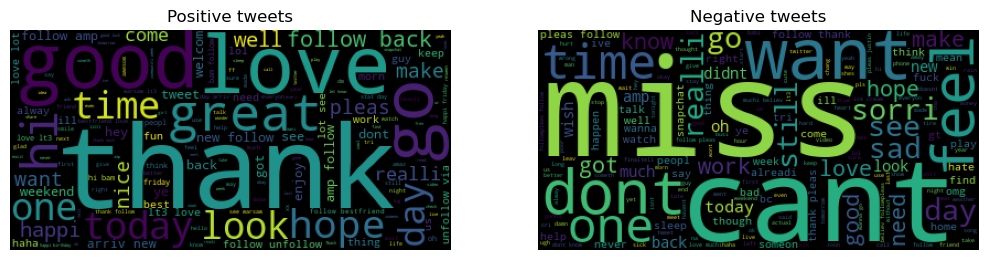

In [11]:
pos_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==1]['cleaned_tweet'])
neg_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==0]['cleaned_tweet'])

plt.figure(figsize=(12.5,3))
plt.subplot(121)
plt.imshow(WordCloud().generate(pos_tweet_cleaned))
plt.title('Positive tweets')
plt.axis('off')
plt.subplot(122)
plt.title('Negative tweets')
plt.imshow(WordCloud().generate(neg_tweet_cleaned))
plt.axis('off')
plt.show()

**Verdict**: The word cloud for positive tweets shows words linked to positive sentiments and emotions, such as thank, love, good, and hope. On the other hand, the word cloud for negative tweets displays words, such as miss, can't, want, don't, and sad. The size of these words indicates their frequency, suggesting that these terms are prominently used in positive or negative tweets.

### 5. Feature extraction
Feature extraction in NLP involves transforming raw text data into numerical representations that can be utilised by machine learning algorithms. In this project, we use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer for feature extraction. TF-IDF normalises the word frequency by their importance in the corpus. In general, it provides better performance than Count vectorizer technique for text classification and information retrieval problems.

In [28]:
# Split the data into 80% training and 20% test sets
X_train, X_cv, y_train, y_cv = train_test_split(tweets_df['cleaned_tweet'], tweets_df['label'], test_size=0.2, stratify=tweets_df['label'])


In [29]:
#Feature extraction using TfidfVectorizer for training and test data
vectorizer = TfidfVectorizer(max_features=2500)
X_train_tfidf = vectorizer.fit_transform(X_train) #The fit_transform method learns from the training data and then transforms it.
#X_cv_tfidf = vectorizer.transform(X_cv) #Transform applies the learned transformation to the test data.
X_test_tfidf = vectorizer.transform(X_test) #Transform applies the learned transformation to the test data.

In [30]:
X_train_tfidf.shape

(6347, 2500)

### 6. Model training and prediction
### ===============Show cross validation study================
During model training, the ML algorithm learns to map input features (X) to output labels (y). In this project, we train 3 models -- Naive Bayes, Logistic regression and Gradient boosting -- that can classify tweets into positive or negative based on the features extracted from the text data.
 - *Naive Bayes*: This classifier is based on Bayes' Theorem and the "naive" assumption that all features (or words) are independent of each other for a given class label.
 - *Logistic regression*: This is a binary classifier that calculates the probability of the target variable belonging to a class (positive or negative) based on the linear combination of input features and a logistic function (sigmoid).
 - *Gradient boosting*: This is an ensemble technique that builds models sequentially with each new model correcting the errors of the previous ones using gradient descent iteration.

In [31]:
#Naive Bayes classifier
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf, y_train)
y_pred_NB = model_NB.predict(X_cv_tfidf)

In [32]:
#Logistic regression classifier
#model_LR = LogisticRegression(class_weight='balanced')
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)
y_pred_LR = model_LR.predict(X_cv_tfidf)

In [33]:
#Gradient boosting classifier
model_GB = GradientBoostingClassifier()
model_GB.fit(X_train_tfidf, y_train)
y_pred_GB = model_GB.predict(X_cv_tfidf)

### 7. Model evaluation
In this section, we evaluate the performance of the trained models using metrics such as accuracy, precision, recall, and F1-score for the two classes of sentiments: Positive (P) and Negative (N).

In [51]:
def get_model_eval_report(classification_reports):
    model_eval_data = {'Metric': ['Accuracy', 'Precision (N)', 'Precision (P)', 'Recall (N)', 'Recall (P)', 'F1-Score (N)', 'F1-Score (P)']}
    for key in classification_reports:
        report = classification_reports[key]
        model_eval_data[key] = [report['accuracy'], report['0']['precision'], report['1']['precision'], report['0']['recall'], report['1']['recall'], 
            report['0']['f1-score'], report['1']['f1-score']]
    
    return pd.DataFrame(model_eval_data)

# Construct the classification reports
report_NB = classification_report(y_cv, y_pred_NB, output_dict=True)
report_LR = classification_report(y_cv, y_pred_LR, output_dict=True)
report_GB = classification_report(y_cv, y_pred_GB, output_dict=True)
classification_reports = {  'Naive Bayes': report_NB,
                            'Logistic Regression': report_LR,
                            'Gradient Boosting': report_GB,
                         }

model_eval_report = get_model_eval_report(classification_reports)
model_eval_report


,Metric,Naive Bayes,Logistic Regression,Gradient Boosting
0,Accuracy,0.741021,0.768116,0.717076
1,Precision (N),0.740506,0.751486,0.660413
2,Precision (P),0.741531,0.786863,0.833013
3,Recall (N),0.739570,0.798989,0.890013
4,Recall (P),0.742462,0.737437,0.545226
5,F1-Score (N),0.740038,0.774510,0.758212
6,F1-Score (P),0.741996,0.761349,0.659074


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


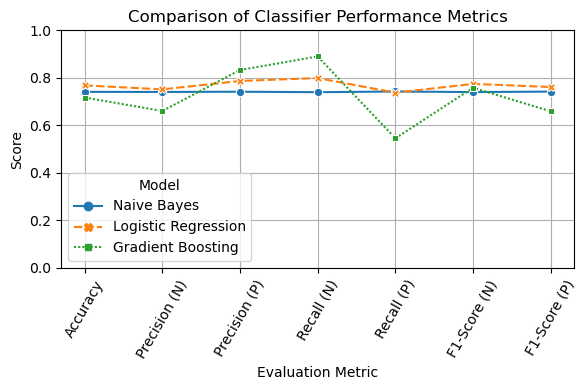

In [52]:

def plot_model_eval_report(model_eval_report):

    report_melted = model_eval_report.melt(id_vars='Metric', var_name='Model', value_name='Score')

    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 10})
    sns.lineplot(x='Metric', y='Score', hue='Model', style='Model', markers=True, data=report_melted)
    plt.title('Comparison of Classifier Performance Metrics')
    plt.xticks(rotation=60)
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.xlabel('Evaluation Metric')
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_eval_report(model_eval_report)

**Verdict**: Based on the evaluation metrics, Naive Bayes and Logistic Regression are very close in terms of performance. They both have an accuracy of 0.755, similar precision, recall, and F1-scores for both classes of sentiments: Positive (P) and Negative (N). Gradient Boosting shows a lower overall performance, particularly in terms of accuracy and F1-score for positive sentiment, suggesting that it is not the best choice for this particular sentiment analysis task.

### 7. Threshold adjustment
#  ========================Include code for Hyperparamater improvement. Check CHatGPT================

Explain hyperparameters

In [111]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Define the model
model = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 50, 100],
    'solver': ['liblinear', 'saga'],
#    'class_weight': ['balanced', None]
}

# Define the scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best F1 Score: {best_f1_score}')


Best Parameters: {'C': 3, 'solver': 'liblinear'}
Best F1 Score: 0.7406953981394668


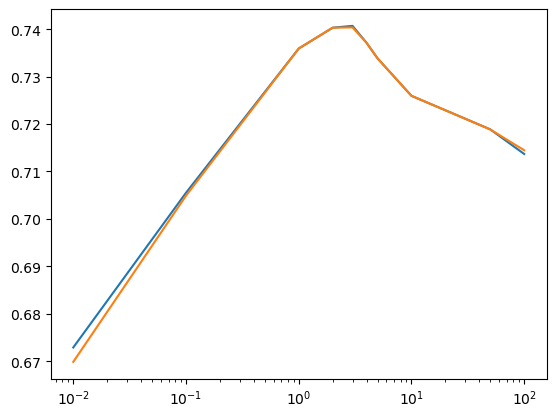

In [112]:
grid_search.cv_results_
plt.semilogx(param_grid['C'],grid_search.cv_results_['mean_test_score'][0::2])
plt.semilogx(param_grid['C'],grid_search.cv_results_['mean_test_score'][1::2])
plt.show()

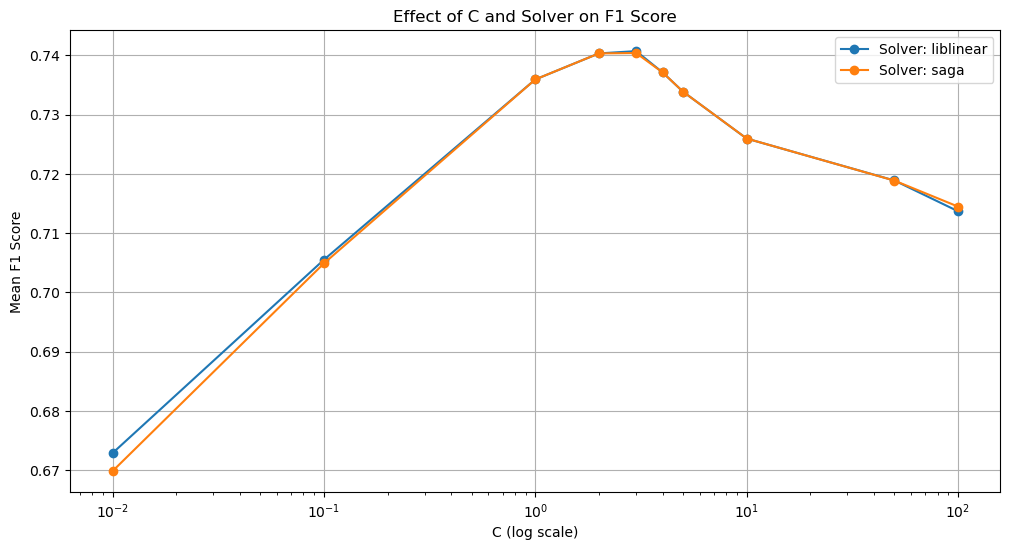

In [113]:
# Extract results
results = pd.DataFrame(grid_search.cv_results_)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot F1 scores for different values of C
for solver in param_grid['solver']:
    mask = results['param_solver'] == solver
    plt.plot(results[mask]['param_C'], results[mask]['mean_test_score'], marker='o', label=f'Solver: {solver}')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean F1 Score')
plt.title('Effect of C and Solver on F1 Score')
plt.legend()
plt.grid(True)
plt.show()

### 7. Threshold adjustment
The logistic regression function does not accept threshold as input. However, it can be done manually ...

Optimal Threshold: 0.4759945776220588
Optimal F1-Score: 0.7671893848009651


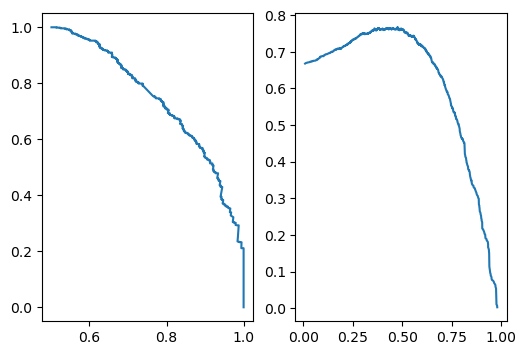

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_tfidf, y_train)

# Predict probabilities on the validation set to adjust threshold
y_cv_probs = final_model.predict_proba(X_cv_tfidf)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_probs)

# Calculate F1-score for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that gives the maximum F1-score
optimal_threshold = thresholds[f1_scores.argmax()]
optimal_f1 = f1_scores.max()

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Optimal F1-Score: {optimal_f1}')

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 10})    
plt.subplot(121)
plt.plot(precision, recall)
plt.subplot(122)
plt.plot(thresholds, f1_scores[:-1])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


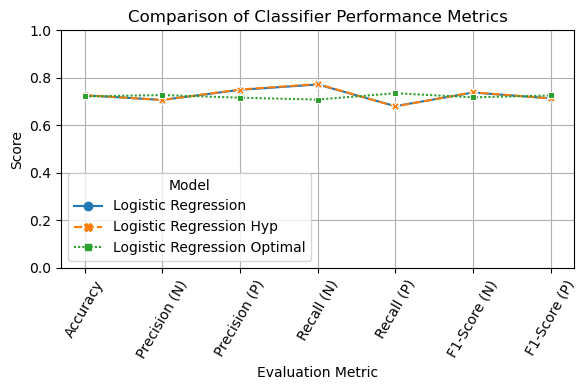

In [67]:
pos_tweets_test = twitter_samples.strings('positive_tweets.json')[4001:]
neg_tweets_test = twitter_samples.strings('negative_tweets.json')[4001:]
tweets_test = pos_tweets_test + neg_tweets_test
label_test = np.zeros(len(tweets_test),dtype='int8')
label_test[:len(pos_tweets_test)] = 1

tweets_df_test = pd.DataFrame([label_test, tweets_test], index=['label', 'tweet']).T
tweets_df_test['label'] = tweets_df_test['label'].astype('int8')

tweets_df_test['cleaned_tweet'] = tweets_df_test['tweet'].apply(tweet_preprocess_pipeline)
tweets_df_test = tweets_df_test[tweets_df_test['cleaned_tweet'].apply(lambda x: x.strip() != '')]
tweets_df_test.reset_index(drop=True, inplace=True)

X_test = tweets_df_test['cleaned_tweet']
y_test = tweets_df_test['label']

X_test_tfidf = vectorizer.transform(X_test) #Transform applies the learned transformation to the test data.

y_test_pred_LR = model_LR.predict(X_test_tfidf)
report_LR = classification_report(y_test, y_test_pred_LR, output_dict=True)

y_test_pred_hyp = final_model.predict(X_test_tfidf)
report_LR_hyp = classification_report(y_test, y_test_pred_hyp, output_dict=True)

y_test_probs = final_model.predict_proba(X_test_tfidf)[:, 1]
y_test_pred_optimal = (y_test_probs >= optimal_threshold).astype('int8')
report_LR_optimal = classification_report(y_test, y_test_pred_optimal, output_dict=True)


# Construct the classification reports
classification_reports = {  'Logistic Regression': report_LR,
                            'Logistic Regression Hyp': report_LR_hyp,
                            'Logistic Regression Optimal': report_LR_optimal
                         }

model_eval_report = get_model_eval_report(classification_reports)
plot_model_eval_report(model_eval_report)

### Evaluating with skewed dataset
sort the test dataset as per label and choose first 80% data. Show using frequency graph